In [2]:
# Importa bibliotecas necessárias:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sympy as sp
import control as ct
from slycot import *
import scienceplots
import latex
import scipy.linalg as scp
import pytask

# Define o estilo dos gráficos:
plt.style.use(['science','no-latex'])

In [3]:
# Parâmetros do sistema
m0  = 1          # Masso do carro
m1  = 1          # Massa do pêndulo inferior
m2  = 1          # Massa do pêndulo superior
L1  = 0.1        # Comprimento do pêndulo inferior
L2  = 0.1        # Comprimento do pêndulo superior
l1  = L1 / 2
l2  = L2 / 2
g   = 9.81       # Aceleração da gravidade
J1  = 0.00083    # Momento de inércia do pêndulo inferior
J2  = 0.00083    # Momento de inércia do pêndulo superior
c0  = 0.01       # Coeficiente de atrito do carro
c1  = 0.007      # Coeficiente viscoso de amortecimento rotacional do pêndulo inferior
c2  = 0.007      # Coeficiente viscoso de amortecimento rotacional do pêndulo superior

Ts = 0.01 # Período de amostragem

# Simplificações
h1 = m0 + m1 + m2
h2 = (m1 + 2 * m2) * l1
h3 = m2 * l2

h4 = J1 + m1 * l1**2 + 4 * m2 * l1**2
h5 = 2 * l1 * l2 * m2
h6 = J2 + m2 * l2**2

w1 = g * l1 * (m1 + 2 * m2)
w2 = g * l2 * m2

In [4]:
# Variáveis simbólicas
#X_carro, Theta1, Theta2, Phi1 ,Phi2= sp.symbols('X_carro Theta1 Theta2 Phi1 Phi2')
X_carro, Phi1, Phi2, DX_carro, DPhi1, DPhi2 = sp.symbols('X_carro Phi1 Phi2 DX_carro Dphi1 Dphi2')

#DX_carro, DTheta1, DTheta2= sp.symbols('DX_carro DTheta1 DTheta2')
#DX_carro, DDTheta1, DDTheta2= sp.symbols('DDX_carro DDTheta1 DDTheta2')

#u = sp.symbols('u') # Entrada
#x_ = sp.Matrix([X_carro, Theta1, Theta2, DX_carro, DTheta1, DTheta2]) # Estados
#x_1 = sp.Matrix([X_carro,Phi1,Phi2])
#x_11 = sp.Matrix([(DX_carro, DTheta1, DTheta2)])
#x_111 = sp.Matrix([(DDX_carro, DDTheta1, DDTheta2)])

# Matriz estados total
x_ = sp.Matrix([X_carro, Phi1, Phi2, DX_carro, DPhi1, DPhi2])


# Matrizes simbólicas na dinâmica não linear
H_nl = sp.Matrix([
    [h1, h2 * sp.cos(x_[1]), h3 * sp.cos(x_[2])],
    [h2 * sp.cos(x_[1]), h4, h5 * sp.cos(x_[1] - x_[2])],
    [h3 * sp.cos(x_[2]), h5 * sp.cos(x_[1] - x_[2]), h6]
])

"""C = sp.Matrix([
    [c0, -2*h2 * sp.sin(Theta1) * DTheta1, -2*h3 * sp.sin(Theta2) * DTheta2],
    [0, c1 + c2, -c2 + 2*h5 * sp.sin(Theta1 - Theta2) * DTheta2],
    [0, -c2 + 2*h5 * sp.sin(Theta1 - Theta2) * DTheta1, c2]
])"""

N_nl = sp.Matrix([
    [c0, -h2 * sp.sin(x_[1]) * x_[4], -h3 * sp.sin(x_[2]) * x_[5]],
    [0, c1 + c2, - c2 + h5 * sp.sin(x_[1] - x_[2]) * x_[5]],
    [0, -c2 - h5 * sp.sin(x_[1] - x_[2]) * x_[4], c2]
])

W_nl = sp.Matrix([
    [0],
    [w1 * sp.sin(x_[1])],
    [w2 * sp.sin(x_[2])]
])

V_nl = sp.Matrix([1, 0, 0])


In [11]:
# Ponto de Linearização:
ponto_de_equilibrio = { X_carro:0,
                       DX_carro:0,
                       Phi1:0,
                       Phi2:0,
                       DPhi1:0,
                       DPhi2:0
                    }

In [12]:
# Matrizes do sistema não linear
Anl = sp.Matrix.hstack(sp.zeros(3, 3), sp.eye(3))
Anl = sp.Matrix.vstack(Anl, sp.Matrix.hstack(sp.zeros(3, 3), -H_nl.inv() * N_nl))

Bnl = sp.Matrix.vstack(sp.zeros(3, 1), H_nl.inv() * V_nl)

Znl = sp.Matrix.vstack(sp.zeros(3, 1), -H_nl.inv() * W_nl)

In [41]:
Anl

Matrix([
[0, 0, 0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1,                                                                                                                                                                                                                                                                                                                                                                   

In [38]:
Znl

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [13]:
# Dinâmica não linear completa do sistema
Eq_nolinear = Anl * x_ + Znl + Bnl * sp.symbols('u')
Eq_nolinear

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [14]:
Anl * x_ + Znl

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
# Linearização - Metodo Jacobiana
A_l = Eq_nolinear.jacobian([x_[0],x_[1],x_[2],x_[3],x_[4],x_[5]])
Ass = A_l.subs(ponto_de_equilibrio)
Ass

Matrix([
[0,                 0,                 0,                    1,                 0,                   0],
[0,                 0,                 0,                    0,                 1,                   0],
[0,                 0,                 0,                    0,                 0,                   1],
[0,  14.7346659068015,   -1.643746964887, -0.00778148791774191,   0.1636452660264, -0.0935517143120879],
[0, -442.335261089952,  147.641942953923,     0.10013364530616, -6.31544305626347,    4.21123182443903],
[0,  442.925828861767, -344.301010968547,  -0.0335116608539653,  9.12761320720641,   -7.02059261459182]])

In [16]:
B_l = Eq_nolinear.jacobian([sp.symbols('u')])
Bss = B_l.subs(ponto_de_equilibrio)
Bss

Matrix([
[                0],
[                0],
[                0],
[0.778148791774191],
[ -10.013364530616],
[ 3.35116608539653]])

In [17]:
Css = sp.eye(6)
Dss = 0

## Sistema Contínuo


In [18]:
# Sistema contínua em espaço de estados:
sys_c_ma = ct.ss(Ass, Bss, Css, Dss)
sys_c_ma


StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.47346659e+01, -1.64374696e+00,
        -7.78148792e-03,  1.63645266e-01, -9.35517143e-02],
       [ 0.00000000e+00, -4.42335261e+02,  1.47641943e+02,
         1.00133645e-01, -6.31544306e+00,  4.21123182e+00],
       [ 0.00000000e+00,  4.42925829e+02, -3.44301011e+02,
        -3.35116609e-02,  9.12761321e+00, -7.02059261e+00]]), array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.77814879],
       [-10.01336453],
       [  3.35116609]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
 

In [20]:
# Matriz de controlabilidade
Co = ct.ctrb(Ass, Bss) # Sis Contínuo

# Ranking da matriz de controlabilidade
ranking_Co = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',ranking_Co)
Co

Rank da Matriz de controlabilidade: 6


array([[ 0.00000000e+00,  7.78148792e-01, -1.95820219e+00,
        -1.29611978e+02,  2.35861372e+03,  3.66560308e+04],
       [ 0.00000000e+00, -1.00133645e+01,  7.74292896e+01,
         3.95075368e+03, -9.33464910e+04, -1.17600005e+06],
       [ 0.00000000e+00,  3.35116609e+00, -1.14951367e+02,
        -4.07515071e+03,  1.38548572e+05,  1.32816657e+06],
       [ 7.78148792e-01, -1.95820219e+00, -1.29611978e+02,
         2.35861372e+03,  3.66560308e+04, -1.92015249e+06],
       [-1.00133645e+01,  7.74292896e+01,  3.95075368e+03,
        -9.33464910e+04, -1.17600005e+06,  7.47698740e+07],
       [ 3.35116609e+00, -1.14951367e+02, -4.07515071e+03,
         1.38548572e+05,  1.32816657e+06, -1.09107804e+08]])

In [21]:
# Matriz de observabilidade
Ob = ct.obsv(Ass,Css)

ranking_Ob = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',ranking_Ob)
Ob

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

In [22]:
# Sintonia do Contolador Contínuo
Q = np.array([[100,0,0,0,0,0],[0,200,0,0,0,0],[0,0,200,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
R = np.array([1])

Kc, Sc, Pc = ct.lqr(sys_c_ma, Q, R) # K - Ganhos do LQR

Kc

array([[10.        , -6.98921244, -2.49006526,  8.89650574, -0.58951742,
        -0.4890622 ]])

In [23]:
# Sistema em Malha fechada - Contínuo
sys_c_mf = ct.ss(Ass - Bss*Kc, Bss, Css, Dss)
sys_c_mf

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-7.78148792e+00,  2.01733131e+01,  2.93894309e-01,
        -6.93058668e+00,  6.22377532e-01,  2.87011444e-01],
       [ 1.00133645e+02, -5.12320793e+02,  1.22708012e+02,
         8.91840887e+01, -1.22184959e+01, -6.85926241e-01],
       [-3.35116609e+01,  4.66347841e+02, -3.35956389e+02,
        -2.98471800e+01,  1.11031840e+01, -5.38166396e+00]]), array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.77814879],
       [-10.01336453],
       [  3.35116609]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
 

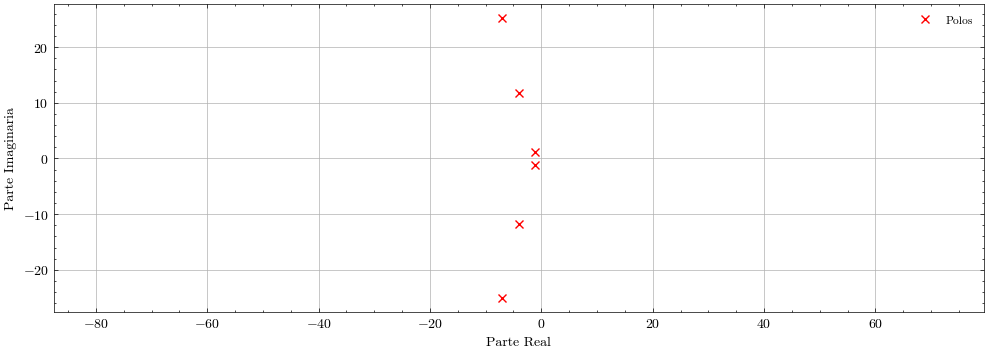

In [24]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO CONTINUO
novo_sys_real = np.real(Pc)
novo_sys_imaginario = np.imag(Pc)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(12, 4))
plt.plot(novo_sys_real,novo_sys_imaginario, 'rx', markersize=6, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend('Polos do sistema')
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)
plt.axis('equal')
plt.show()


In [25]:
# Simulações

# Simular o sistema linear contínuo para condições iniciais

t_c_mf = np.arange(0, 5, Ts) 
x0_c_mf = np.array([[0.0],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])

t_cmf,y_cmf = ct.initial_response(sys_c_mf, t_c_mf, x0_c_mf)

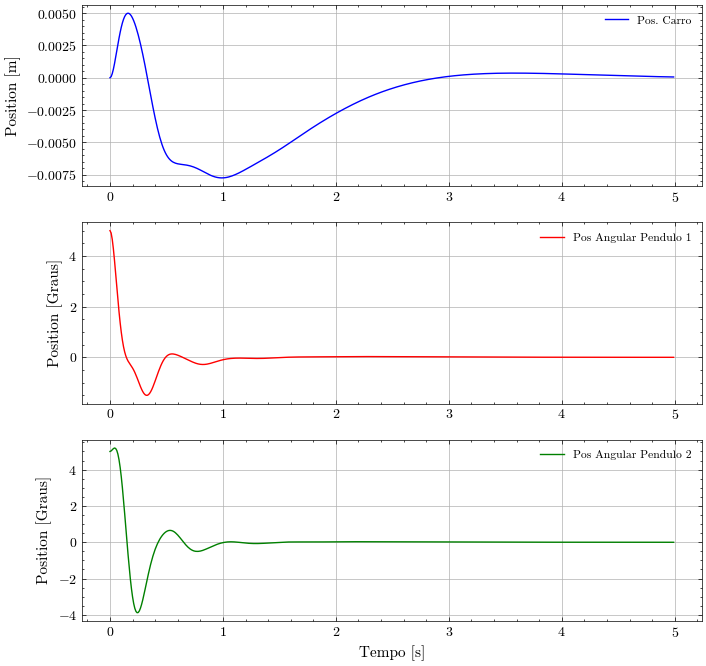

In [26]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t_cmf,y_cmf[0],'b',linewidth=1,label='Pos. Carro')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t_cmf,y_cmf[1]*180/np.pi,'r',linewidth=1,label='Pos Angular Pendulo 1')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t_cmf,y_cmf[2]*180/np.pi,'g',linewidth=1,label='Pos Angular Pendulo 2')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

## Sistema Discreto

In [27]:
# Definindo o sistema discreto
sys_d_ma = ct.c2d(sys_c_ma, Ts,method='zoh')

Ad = sys_d_ma.A
Bd = sys_d_ma.B
Cd = sys_d_ma.C
Dd = sys_d_ma.D

In [28]:
# Matriz de controlabilidade

Cod = ct.ctrb(Ad, Bd) # Sis Discreto

# Ranking da matriz de controlabilidade
ranking_Cod = np.linalg.matrix_rank(Cod)    
print('Rank da Matriz de controlabilidade:',ranking_Cod)
Cod

Rank da Matriz de controlabilidade: 6


array([[ 3.85290802e-05,  1.13691333e-04,  1.85266741e-04,
         2.52479199e-04,  3.14819498e-04,  3.72031148e-04],
       [-4.86196472e-04, -1.38947401e-03, -2.16834860e-03,
        -2.80332744e-03, -3.28486123e-03, -3.61258197e-03],
       [ 1.46818850e-04,  3.46763571e-04,  3.88563238e-04,
         2.60313756e-04, -3.60709469e-05, -4.86295486e-04],
       [ 7.66298646e-03,  7.35206536e-03,  6.95008026e-03,
         6.48394883e-03,  5.97988090e-03,  5.46200615e-03],
       [-9.56434929e-02, -8.45173747e-02, -7.09330148e-02,
        -5.59048966e-02, -4.03977786e-02, -2.52756462e-02],
       [ 2.71435856e-02,  1.24054641e-02, -4.24282443e-03,
        -2.13727359e-02, -3.76624822e-02, -5.19678365e-02]])

In [29]:
# Matriz de observabilidade

Obd = ct.obsv(Ad, Cd) # Sis Discreto

ranking_Obd = np.linalg.matrix_rank(Obd)    
print('Rank da Matriz de observabilidade:',ranking_Obd)
Obd

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  7.15438108e-04, -7.20146461e-05,
         9.99961471e-03,  1.02381357e-05, -4.68000173e-06],
       [ 0.00000000e+00,  9.78739286e-01,  6.95179145e-03,
         4.86196472e-06,  9.62689281e-03,  2.23895429e-04],
       [ 0.00000000e+00,  2.08553744e-02,  9.834

In [30]:
# Sintonia do Contolador Discreto

Kd, Sd, Pd = ct.dlqr(sys_d_ma, Q, R) # K - Ganhos do LQR

Kd


array([[ 9.45654744, -5.74406485, -2.03875575,  8.4602489 , -0.5849492 ,
        -0.47323185]])

In [31]:
# Sistema em Malha fechada - Discreto

Ad_mf = Ad - Bd@Kd
Bd_mf = Bd
Cd_mf = Cd
Dd_mf = Dd

sys_d_mf = ct.ss(Ad_mf, Bd_mf, Cd_mf, Dd_mf, Ts)


print(sys_d_mf)

<StateSpace>: sys[3]
Inputs (1): ['u[0]']
Outputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 9.99635648e-01  9.36751644e-04  6.53673774e-06  9.67364910e-03
       3.27756903e-05  1.35531861e-05]
     [ 4.59774000e-03  9.75946542e-01  5.96055560e-03  4.11820513e-03
       9.34249258e-03 -6.18822645e-06]
     [-1.38839942e-03  2.16987114e-02  9.83764882e-01 -1.24359221e-03
       5.90908494e-04  9.67859630e-03]
     [-7.24653949e-02  1.84756091e-01  2.30902895e-03  9.35092597e-01
       6.72690990e-03  2.69484505e-03]
     [ 9.04457228e-01 -4.70845586e+00  1.14924402e+00  8.10124191e-01
       8.64039035e-01  6.58988442e-04]
     [-2.56684605e-01  4.18862775e+00 -3.17852397e+00 -2.29912926e-01
       1.21251587e-01  9.30975991e-01]]

B = [[ 3.85290802e-05]
     [-4.86196472e-04]
     [ 1.46818850e-04]
     [ 7.66298646e-03]
     [-9.56434929e-02]
     [ 2.71435856e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0

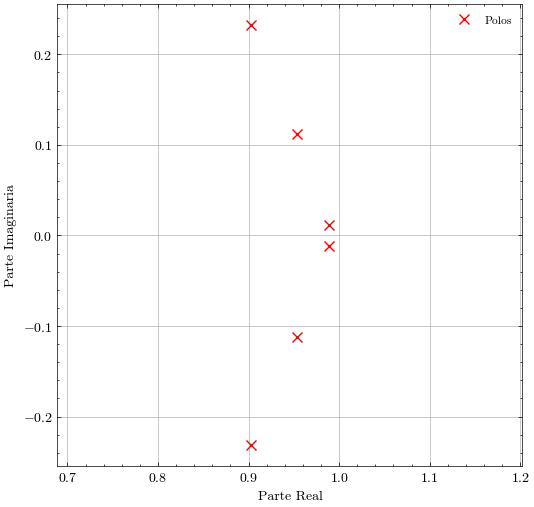

In [32]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO DISCRETO

sys_discreto_real = np.real(Pd)
sys_discreto_imaginario = np.imag(Pd)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(6, 6))
plt.plot(sys_discreto_real,sys_discreto_imaginario, 'rx', markersize=7, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)
plt.axis('equal')
plt.show()

In [33]:
# Simulações

# Simular o sistema linear discreto para condições iniciais

t_d_mf = np.arange(0, 5, Ts) 
x0_d_mf = np.array([[0.0],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])

t_dmd,y_dmf = ct.initial_response(sys_d_mf, t_d_mf, x0_d_mf)


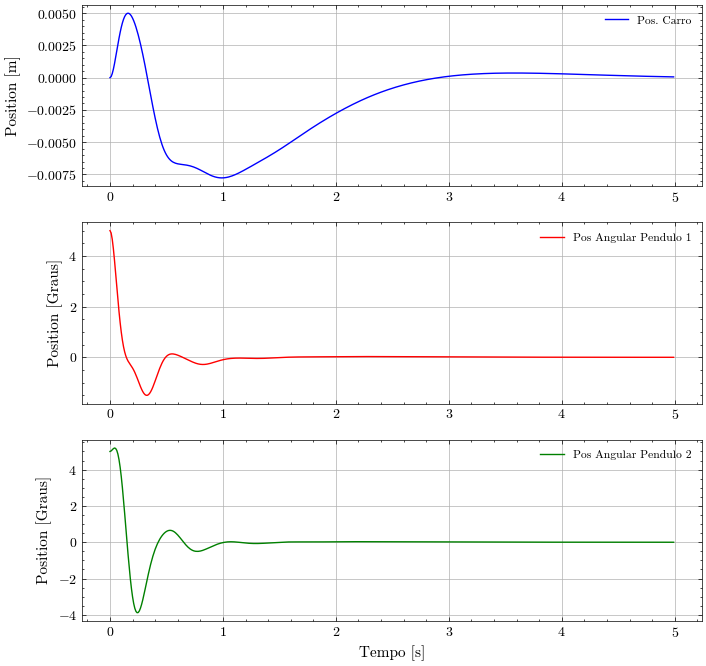

In [34]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t_dmd,y_dmf[0],'b',linewidth=1,label='Pos. Carro')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t_dmd,y_dmf[1]*180/np.pi,'r',linewidth=1,label='Pos Angular Pendulo 1')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t_dmd,y_dmf[2]*180/np.pi,'g',linewidth=1,label='Pos Angular Pendulo 2')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

## Sistema Não Linear

In [35]:
# Trazendo o ganho K

K = Kc

In [36]:
# Dinâmica não linear do sistema
def nlode(x, t, K, Anl, Bnl, Znl):
    A = np.array(Anl.subs({X_carro: x[0], Phi1: x[1], Phi2: x[2], DX_carro: x[3], DPhi1: x[4], DPhi2: x[5]})).astype(np.float64)
    B = np.array(Bnl.subs({X_carro: x[0], Phi1: x[1], Phi2: x[2], DX_carro: x[3], DPhi1: x[4], DPhi2: x[5]})).astype(np.float64)
    H = np.array(Znl.subs({X_carro: x[0], Phi1: x[1], Phi2: x[2], DX_carro: x[3], DPhi1: x[4], DPhi2: x[5]})).astype(np.float64)
    
    u =-K@x  # Controlador LQR
    
    dxdt =  np.dot(A, x) + H.flatten() + np.dot(B, u)
    return dxdt.flatten()

In [37]:
# Simular modelo não linear com odeint
x0 = [0, np.deg2rad(5), np.deg2rad(5),0,0,0]
#t = np.linspace(0, 5, 500)
t = np.arange(0, 5, Ts) 
x = odeint(nlode, x0, t, args=(K, Anl, Bnl, Znl))

In [40]:
# Converter de radianos para graus
x.T[1]= np.rad2deg(x.T[1])
x.T[2] = np.rad2deg(x.T[2])

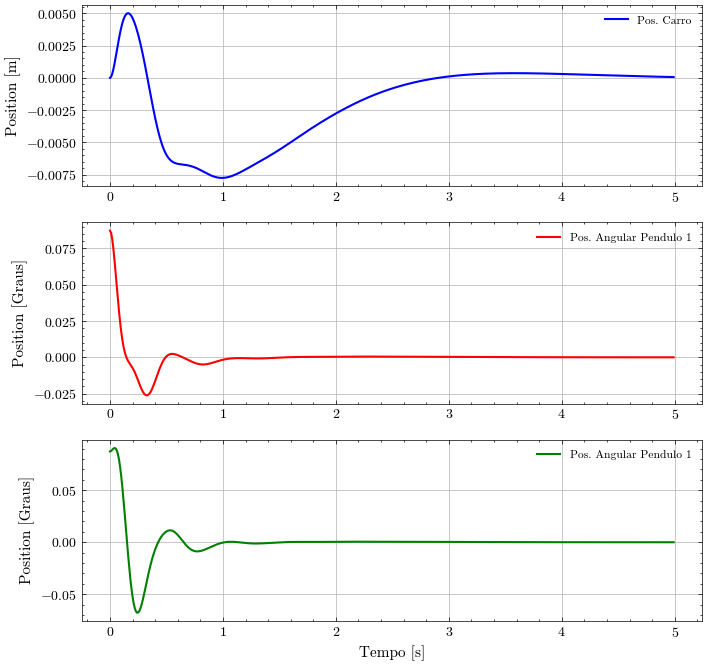

In [49]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t,x.T[0],'b',linewidth=1.5,label='Pos. Carro')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,x.T[1],'r',linewidth=1.5,label='Pos. Angular Pendulo 1')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,x.T[2],'g',linewidth=1.5,label='Pos. Angular Pendulo 1')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

## Comparação - Linear x Não Linear


In [184]:
len(y_dmf[0])

500

In [185]:
len(x.T[0])

500

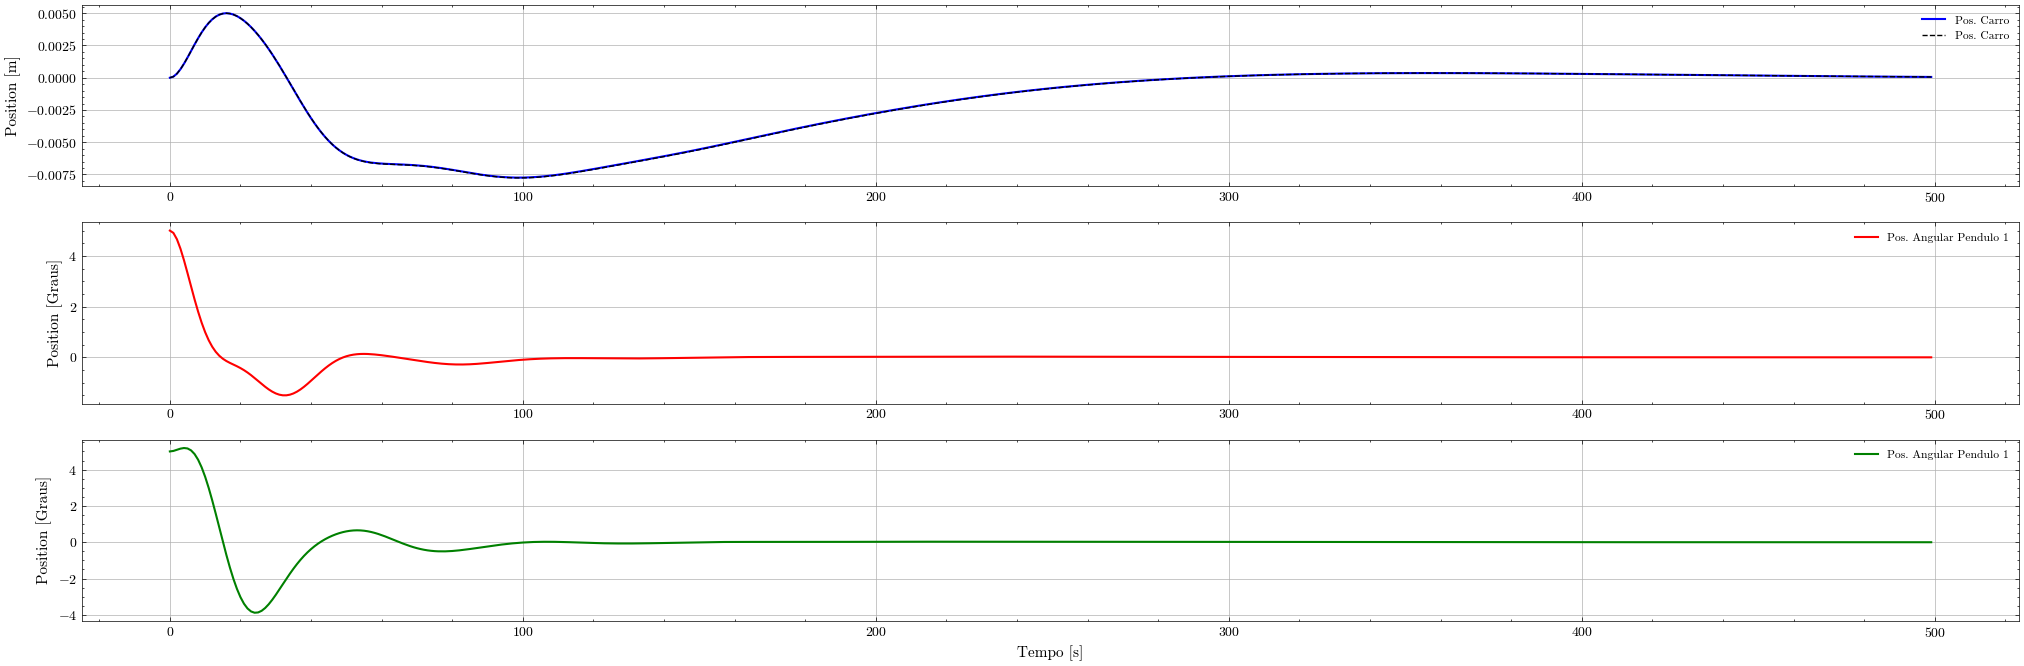

In [188]:
plt.figure(figsize=(25,8))

plt.subplot(3,1,1)
plt.plot(x.T[0],'b',linewidth=1.5,label='Pos. Carro')
plt.plot(y_dmf[0],'--k',linewidth=1,label='Pos. Carro')
#plt.plot(tdma,ydma[0],'r',linewidth=2,label='Pos. carro')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(x.T[1],'r',linewidth=1.5,label='Pos. Angular Pendulo 1')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(x.T[2],'g',linewidth=1.5,label='Pos. Angular Pendulo 1')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()